Analyze data with PAAT
======================

In [1]:
import h5py
import paat
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle, Patch
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 3]
plt.rcParams['font.size'] = '13'

Load the example data
---------------------

Normally, the `paat.io.read_gt3x` would be used to load the acceleration data. However, to save storage space and runtime, we provide a gunzipped CSV file with an already calibrated one day recording to visualize the analysis options currently available in PAAT.

In [2]:
data, sample_freq = pd.read_csv("data/example_day_calibrated.csv.tar.gz", compression='gzip'), 100
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

Visualize the raw data
----------------------

It is often good, when developing analysis scripts, to have sneak peeks into the data to get a feeling for the quality and what to expect. There is no dedicated function for this in PAAT as what you are looking for might severly vary between applications and research questions. One of the easiest ways to visualize the data is using [Seaborn](https://seaborn.pydata.org/). Seaborn provides a simple, but yet powerful, interface to the way more versatile [Matplotlib](https://matplotlib.org/) library. To visualize the data, we recommend to resample it to `1min` or `1s` resolution as plotting otherwise takes ages. However, certain applications might require higher resolutions.

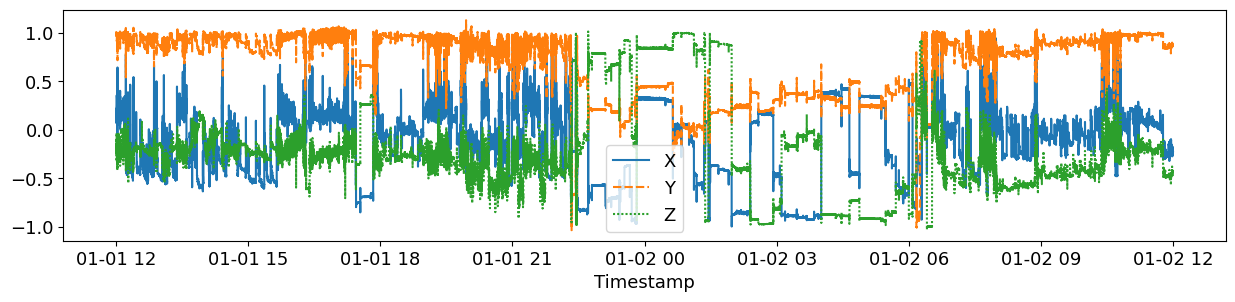

In [3]:
agg = data.resample("1s").mean()

ax = sns.lineplot(data=agg[['X', 'Y', 'Z']], legend=True)

While this plot already provides some insights, we recoomend to pretify the plot a little bit to facilitate readability:

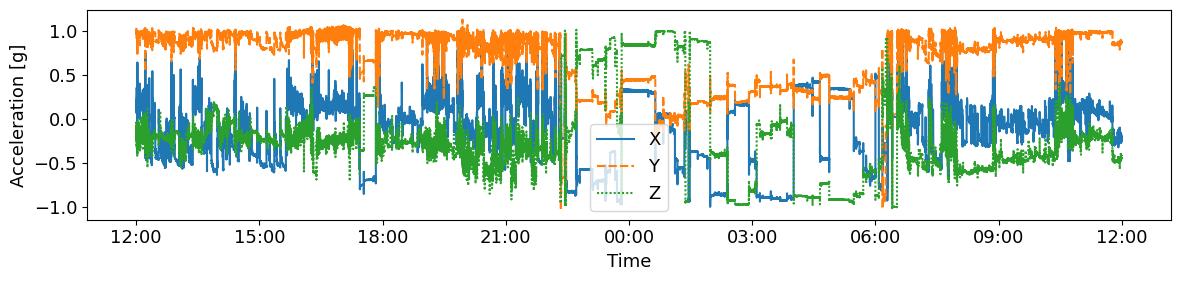

In [4]:
agg = data.resample("1s").mean()

fig, ax = plt.subplots(figsize=(12,3))
ax = sns.lineplot(data=agg[['X', 'Y', 'Z']], ax=ax, legend=True)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel("Time")
ax.set_ylabel("Acceleration [g]")

plt.tight_layout()
print('')

Detect non-wear periods
-----------------------

Different methods to infer non-wear time from the raw acceleration signal are
implemented in the `paat.wear_time` module. We suggest to use
`paat.wear_time.detect_non_wear_time_hees2011` published by Van Hees et al. (2011,2013) as it is the most validated algorithm. This function can also be called from the top-level:

In [5]:
data.loc[:, "Non Wear Time"] = paat.detect_non_wear_time_hees2011(data, sample_freq)

However, there are also other non-wear time algorithm implemented in the `paat.wear_time`
module. For instance, the CNN-based NWT method by Syed et al. (2021) is also implemented and can be used by calling:

In [6]:
data.loc[:, "Non Wear Time Syed"] = paat.detect_non_wear_time_syed2021(data, sample_freq)

Finally, also a very naive NWT algorithm is implemented in `paat.wear_time.detect_non_wear_time_naive`. For a comparison of the different algorithms see also Syed et al. (2020).

In [7]:
data.loc[:, "Non Wear Time Naive"] = paat.detect_non_wear_time_naive(
    data, 
    sample_freq, 
    std_threshold=.003, 
    min_interval=5
)

Identify Time in Bed periods
----------------------------



In [8]:
data.loc[:, "Time in bed"] = paat.detect_time_in_bed_weitz2024(data, sample_freq)

Estimate physical activity and sedentary behavior
-------------------------------------------------

The most common approach to analyze physical activity data is the use of cutpoints. There are [various published cutpoints](https://cran.r-project.org/web/packages/GGIR/vignettes/CutPoints.html) for different demographical groups. In this example, we use the cutpoints proposed by Sanders et al. (2019). 

In [9]:
data.loc[:, ["MVPA", "SB"]] = paat.calculate_pa_levels(
    data, 
    sample_freq, 
    mvpa_cutpoint=0.069, 
    sb_cutpoint=0.015
)

Combine the estimates into one column
-------------------------------------

To simplify the data, *paat* has a `create_activity_column` functions, which creates one activity column from the different columns. The importance of column is the revised order of the `columns` argument. So in this example, first NWT is marked. Then everything which was not marked as NWT is marked as time in bed, and so on.

In [10]:
data.loc[:, "Activity"] = paat.create_activity_column(
    data, 
    columns=["SB", "MVPA", "Time in bed", "Non Wear Time"]
)
data =  data[["X", "Y", "Z", "Activity"]]
data["ENMO"] = paat.calculate_enmo(data)

Visualize and analyze the results
---------------------------------

Finally, it can be helpful to visually investigate the results. Below a simple example is provided how the resulting data frame can be visualized. However, note that especially with larger datasets visualizing this data on 1s resolution takes a considerable amount of time.

As physical activity, in this example, is dependent on the ENMO of the acceleration signal, it can be useful to plot the resulting estimates against the ENMO:

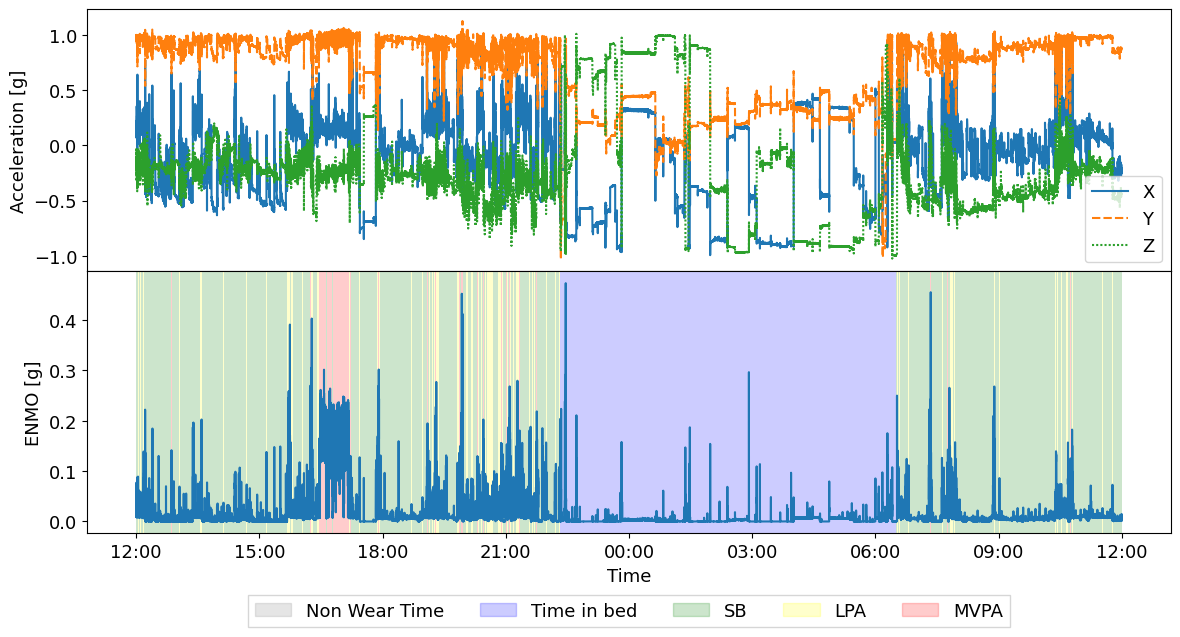

In [11]:
agg = data.resample("1s").apply({
    "X": "mean", 
    "Y": "mean", 
    "Z": "mean", 
    "ENMO": "mean", 
    "Activity": pd.Series.mode
})

COLOR = {
    'Non Wear Time': "grey", 
    'Time in bed': "blue", 
    'SB': "green", 
    'LPA': "yellow", 
    'MVPA': "red"
}

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,6.5))

ax = axes[0]
ax = sns.lineplot(data=agg[['X', 'Y', 'Z']], ax=ax, legend=True)
ax.set_ylabel("Acceleration [g]")

ax = axes[1]
ax = sns.lineplot(data=agg['ENMO'], ax=ax, legend=True)

# Add background
ymin, ymax = ax.get_ylim()
height = ymax - ymin
for ii, row in agg.iterrows():
    ax.add_patch(
        Rectangle(
            (ii, ymin), 
            pd.Timedelta("1s"), 
            height, 
            alpha=.2, 
            facecolor=COLOR[row["Activity"]]
        )
    )
    

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel("Time")
ax.set_ylabel("ENMO [g]")

handles = [Patch(color=value, label=key, alpha=.2) for key, value in COLOR.items()]
ax.legend(
    handles=handles, 
    loc='upper center', 
    bbox_to_anchor=(0.5, -.4 * ymax), 
    fancybox=False, 
    shadow=False, 
    ncol=5)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
print('')

References
----------

Sanders, G. J., Boddy, L. M., Sparks, S. A., Curry, W. B., Roe, B., Kaehne, A., & Fairclough, S. J. 
(2019). Evaluation of wrist and hip sedentary behaviour and moderate-to-vigorous physical activity 
raw acceleration cutpoints in older adults. *Journal of Sports Sciences*, 37(11), 1270–1279. 
https://doi.org/10.1080/02640414.2018.1555904

Syed, S., Morseth, B., Hopstock, L. A., & Horsch, A. (2020). Evaluating the performance of raw and epoch 
non-wear algorithms using multiple accelerometers and electrocardiogram recordings. *Scientific Reports*, 
10(1), 1. https://doi.org/10.1038/s41598-020-62821-2

Syed, S., Morseth, B., Hopstock, L. A., & Horsch, A. (2021). A novel algorithm to detect non-wear time 
from raw accelerometer data using deep convolutional neural networks. *Scientific Reports*, 11(1), 8832. 
https://doi.org/10.1038/s41598-021-87757-z

Van Hees, V. T., Gorzelniak, L., León, E. C. D., Eder, M., Pias, M., Taherian, S., Ekelund, U., Renström, F., 
Franks, P. W., Horsch, A., & Brage, S. (2013). Separating Movement and Gravity Components in an Acceleration 
Signal and Implications for the Assessment of Human Daily Physical Activity. *PLOS ONE*, 8(4), e61691. 
https://doi.org/10.1371/journal.pone.0061691

Van Hees, V. T., Renström, F., Wright, A., Gradmark, A., Catt, M., Chen, K. Y., Löf, M., Bluck, L., Pomeroy, J.,
Wareham, N. J., Ekelund, U., Brage, S., & Franks, P. W. (2011). Estimation of Daily Energy Expenditure in Pregnant 
and Non-Pregnant Women Using a Wrist-Worn Tri-Axial Accelerometer. *PLOS ONE*, 6(7), 7. 
https://doi.org/10.1371/journal.pone.0022922
